# 코호트 분석 보고서 (Cohort Analysis Report)

## 1. 분석 개요

### 1.1 분석 목적
- 고객 유지율(Retention Rate) 파악
- 코호트별 고객 행동 패턴 분석
- 고객 생애 가치(LTV) 산출
- 마케팅 전략 수립을 위한 인사이트 도출

### 1.2 라이브러리 및 데이터 로드

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# 한글 폰트 설정 (Mac)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 데이터 로드
df = pd.read_csv('data/online_retail_preprocessed.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 매출 계산
df['Sales'] = df['Quantity'] * df['UnitPrice']

# 월별 처리
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M').dt.to_timestamp()
df['FirstOrderDate'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')
df['CohortIndex'] = (
    (df['InvoiceMonth'].dt.year - df['FirstOrderDate'].dt.year) * 12 +
    (df['InvoiceMonth'].dt.month - df['FirstOrderDate'].dt.month)
)

print("데이터 로드 완료")

데이터 로드 완료


### 1.3 데이터 요약

In [3]:
# 데이터 요약 테이블
summary_data = {
    '항목': ['분석 기간', '총 거래 건수', '고유 고객 수', '고유 상품 수', '대상 국가 수', '총 매출'],
    '값': [
        f"{df['InvoiceDate'].min().strftime('%Y-%m-%d')} ~ {df['InvoiceDate'].max().strftime('%Y-%m-%d')}",
        f"{len(df):,}건",
        f"{df['CustomerID'].nunique():,}명",
        f"{df['StockCode'].nunique():,}개",
        f"{df['Country'].nunique()}개국",
        f"${df['Sales'].sum():,.2f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df.style.hide(axis='index')

항목,값
분석 기간,2010-12-01 ~ 2011-12-09
총 거래 건수,"392,692건"
고유 고객 수,"4,338명"
고유 상품 수,"3,665개"
대상 국가 수,37개국
총 매출,"$8,887,208.89"


---
## 2. 월별 코호트 리텐션 분석

### 2.1 코호트별 초기 고객 수

In [4]:
# 코호트별 고객 수 계산
cohort_counts = df.groupby(['FirstOrderDate', 'CohortIndex'])['CustomerID'].nunique().unstack()
cohort_size = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_size, axis=0)

# 코호트별 초기 고객 수 및 비중
total_customers = cohort_size.sum()
cohort_summary = pd.DataFrame({
    '코호트': cohort_size.index.strftime('%Y-%m'),
    '신규 고객 수': cohort_size.values.astype(int),
    '비중': (cohort_size.values / total_customers * 100).round(1)
})
cohort_summary['비중'] = cohort_summary['비중'].apply(lambda x: f"{x}%")
cohort_summary

,코호트,신규 고객 수,비중
0,2010-12,885,20.4%
1,2011-01,417,9.6%
2,2011-02,380,8.8%
3,2011-03,452,10.4%
4,2011-04,300,6.9%
5,2011-05,284,6.5%
6,2011-06,242,5.6%
7,2011-07,188,4.3%
8,2011-08,169,3.9%
9,2011-09,299,6.9%


### 2.2 리텐션 히트맵

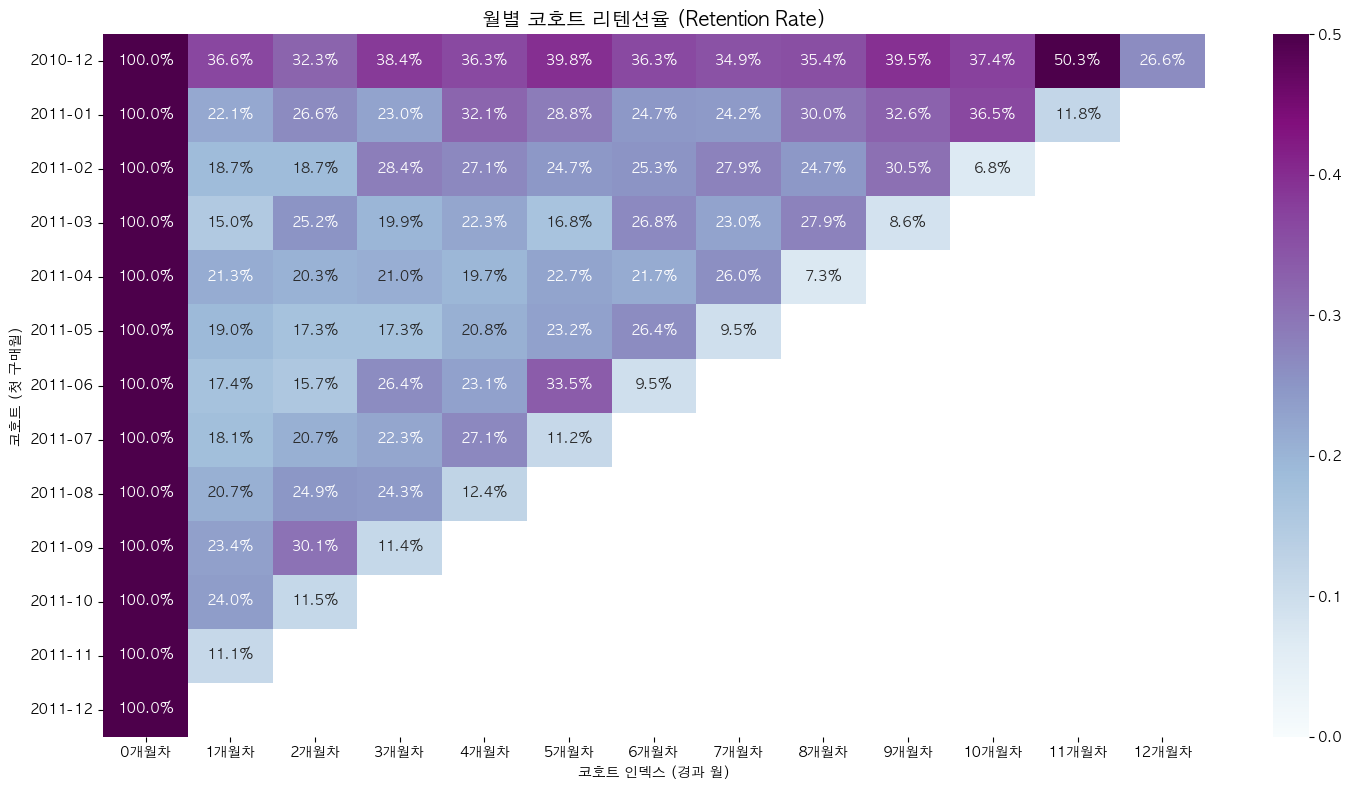

In [5]:
# 리텐션율 히트맵
plt.figure(figsize=(15, 8))
plt.title('월별 코호트 리텐션율 (Retention Rate)', fontsize=14, fontweight='bold')
sns.heatmap(
    data=retention,
    annot=True,
    fmt='.1%',
    vmin=0.0,
    vmax=0.5,
    cmap="BuPu",
    xticklabels=[f'{i}개월차' for i in range(retention.shape[1])],
    yticklabels=retention.index.strftime('%Y-%m')
)
plt.xlabel('코호트 인덱스 (경과 월)')
plt.ylabel('코호트 (첫 구매월)')
plt.tight_layout()
plt.show()

### 2.3 평균 리텐션율 추이

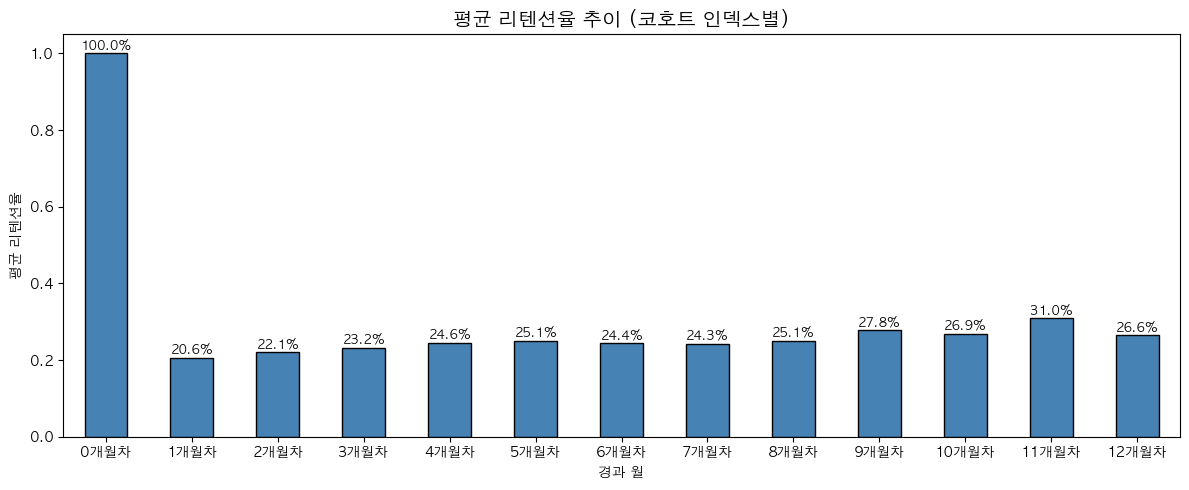


핵심 인사이트:
- 첫 달에 약 79.4%의 고객이 이탈
- 첫 달 이후 리텐션율은 20~25% 수준에서 안정적으로 유지


In [6]:
# 평균 리텐션율 계산
avg_retention = retention.mean()

# 시각화
fig, ax = plt.subplots(figsize=(12, 5))
avg_retention.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('평균 리텐션율 추이 (코호트 인덱스별)', fontsize=14, fontweight='bold')
ax.set_xlabel('경과 월')
ax.set_ylabel('평균 리텐션율')
ax.set_xticklabels([f'{i}개월차' for i in range(len(avg_retention))], rotation=0)

# 값 표시
for i, v in enumerate(avg_retention):
    if not pd.isna(v):
        ax.text(i, v + 0.01, f'{v:.1%}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n핵심 인사이트:")
print(f"- 첫 달에 약 {(1-avg_retention[1])*100:.1f}%의 고객이 이탈")
print(f"- 첫 달 이후 리텐션율은 20~25% 수준에서 안정적으로 유지")

---
## 3. 국가별 코호트 분석

In [7]:
# 국가별 분석
top_countries = df['Country'].value_counts().head(5).index.tolist()

country_stats = []
for country in top_countries:
    country_df = df[df['Country'] == country]
    country_cohort = country_df.groupby(['FirstOrderDate', 'CohortIndex'])['CustomerID'].nunique().unstack()
    country_size = country_cohort.iloc[:, 0]
    country_retention = country_cohort.divide(country_size, axis=0)
    
    avg_ret = country_retention.iloc[:, 1:].mean().mean() if country_retention.shape[1] > 1 else 0
    
    country_stats.append({
        '국가': country,
        '고객 수': country_df['CustomerID'].nunique(),
        '총 매출': country_df['Sales'].sum(),
        '평균 리텐션율': avg_ret
    })

country_df_result = pd.DataFrame(country_stats)
country_df_result['총 매출'] = country_df_result['총 매출'].apply(lambda x: f"${x:,.2f}")
country_df_result['평균 리텐션율'] = country_df_result['평균 리텐션율'].apply(lambda x: f"{x*100:.1f}%")
country_df_result

,국가,고객 수,총 매출,평균 리텐션율
0,United Kingdom,3920,"$7,285,024.64",25.1%
1,Germany,94,"$228,678.40",36.5%
2,France,87,"$208,934.31",36.4%
3,EIRE,3,"$265,262.46",72.2%
4,Spain,30,"$61,558.56",43.9%


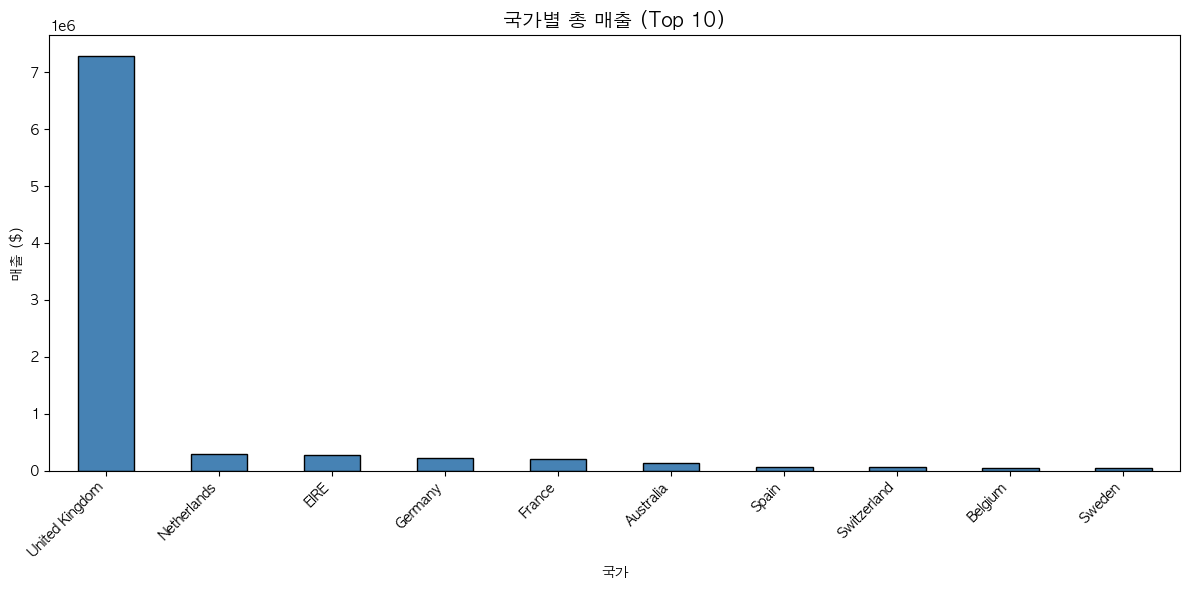


핵심 인사이트:
- 독일과 프랑스가 가장 높은 리텐션율 기록 (36%대)
- UK가 전체 매출의 82%를 차지하지만, 리텐션율은 상대적으로 낮음


In [8]:
# 국가별 매출 시각화
country_sales = df.groupby('Country')['Sales'].sum().sort_values(ascending=False).head(10)

fig, ax = plt.subplots(figsize=(12, 6))
country_sales.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('국가별 총 매출 (Top 10)', fontsize=14, fontweight='bold')
ax.set_xlabel('국가')
ax.set_ylabel('매출 ($)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\n핵심 인사이트:")
print("- 독일과 프랑스가 가장 높은 리텐션율 기록 (36%대)")
print("- UK가 전체 매출의 82%를 차지하지만, 리텐션율은 상대적으로 낮음")

---
## 4. 고객 세그먼트별 분석

### 4.1 구매금액 기준 세그먼트

In [9]:
# 고객별 총 구매금액 계산
customer_revenue = df.groupby('CustomerID')['Sales'].sum()

# 분위수 기준 세그먼트 분류
q75 = customer_revenue.quantile(0.75)
q25 = customer_revenue.quantile(0.25)

high_value_customers = customer_revenue[customer_revenue >= q75].index
medium_value_customers = customer_revenue[(customer_revenue >= q25) & (customer_revenue < q75)].index
low_value_customers = customer_revenue[customer_revenue < q25].index

print(f"세그먼트 분류 기준:")
print(f"  High Value: 구매금액 >= ${q75:,.2f}")
print(f"  Medium Value: ${q25:,.2f} <= 구매금액 < ${q75:,.2f}")
print(f"  Low Value: 구매금액 < ${q25:,.2f}")

세그먼트 분류 기준:
  High Value: 구매금액 >= $1,660.60
  Medium Value: $306.48 <= 구매금액 < $1,660.60
  Low Value: 구매금액 < $306.48


In [10]:
# 세그먼트별 통계 계산
segment_stats = []

for segment_name, segment_customers in [('High Value', high_value_customers), 
                                         ('Medium Value', medium_value_customers),
                                         ('Low Value', low_value_customers)]:
    segment_df = df[df['CustomerID'].isin(segment_customers)]
    segment_cohort = segment_df.groupby(['FirstOrderDate', 'CohortIndex'])['CustomerID'].nunique().unstack()
    segment_size = segment_cohort.iloc[:, 0]
    segment_retention = segment_cohort.divide(segment_size, axis=0)
    
    avg_ret = segment_retention.iloc[:, 1:].mean().mean() if segment_retention.shape[1] > 1 else 0
    
    segment_stats.append({
        '세그먼트': segment_name,
        '고객 수': len(segment_customers),
        '평균 구매금액': customer_revenue[segment_customers].mean(),
        '평균 리텐션율': avg_ret
    })

segment_df_result = pd.DataFrame(segment_stats)
segment_df_result

,세그먼트,고객 수,평균 구매금액,평균 리텐션율
0,High Value,1085,6486.259337,0.481213
1,Medium Value,2168,764.045726,0.184877
2,Low Value,1085,178.033530,0.034692


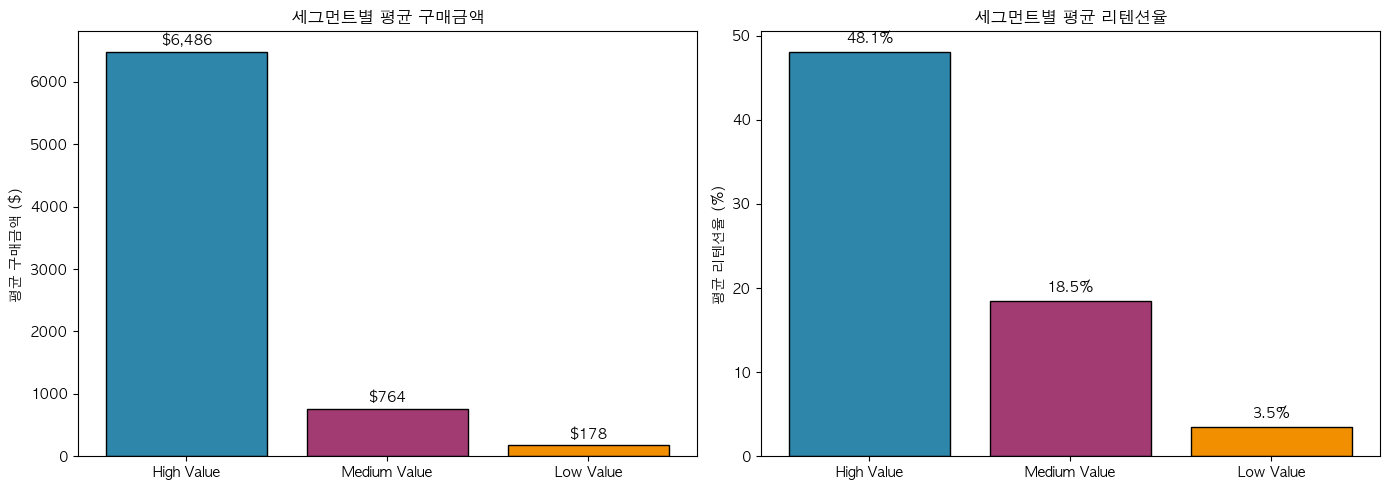


핵심 인사이트:
- High Value 고객의 리텐션율이 Low Value 대비 13.9배 높음
- 상위 25% 고객이 전체 매출의 대부분 기여


In [11]:
# 세그먼트별 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 평균 구매금액
colors = ['#2E86AB', '#A23B72', '#F18F01']
axes[0].bar(segment_df_result['세그먼트'], segment_df_result['평균 구매금액'], color=colors, edgecolor='black')
axes[0].set_title('세그먼트별 평균 구매금액', fontsize=12, fontweight='bold')
axes[0].set_ylabel('평균 구매금액 ($)')
for i, v in enumerate(segment_df_result['평균 구매금액']):
    axes[0].text(i, v + 100, f'${v:,.0f}', ha='center', fontsize=10)

# 평균 리텐션율
axes[1].bar(segment_df_result['세그먼트'], segment_df_result['평균 리텐션율'] * 100, color=colors, edgecolor='black')
axes[1].set_title('세그먼트별 평균 리텐션율', fontsize=12, fontweight='bold')
axes[1].set_ylabel('평균 리텐션율 (%)')
for i, v in enumerate(segment_df_result['평균 리텐션율']):
    axes[1].text(i, v * 100 + 1, f'{v*100:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n핵심 인사이트:")
print(f"- High Value 고객의 리텐션율이 Low Value 대비 {segment_df_result.iloc[0]['평균 리텐션율']/segment_df_result.iloc[2]['평균 리텐션율']:.1f}배 높음")
print("- 상위 25% 고객이 전체 매출의 대부분 기여")

### 4.2 구매 빈도별 세그먼트

In [12]:
# 고객별 구매 빈도
customer_frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()

freq_high = customer_frequency[customer_frequency >= 5].index
freq_medium = customer_frequency[(customer_frequency >= 2) & (customer_frequency < 5)].index
freq_low = customer_frequency[customer_frequency == 1].index

freq_stats = []
for freq_name, freq_customers in [('고빈도 (5회+)', freq_high), 
                                   ('중빈도 (2-4회)', freq_medium),
                                   ('저빈도 (1회)', freq_low)]:
    freq_df = df[df['CustomerID'].isin(freq_customers)]
    avg_sales = freq_df.groupby('CustomerID')['Sales'].sum().mean()
    freq_stats.append({
        '구분': freq_name,
        '고객 수': len(freq_customers),
        '비중': len(freq_customers) / df['CustomerID'].nunique() * 100,
        '평균 총 구매금액': avg_sales
    })

freq_df_result = pd.DataFrame(freq_stats)
freq_df_result['비중'] = freq_df_result['비중'].apply(lambda x: f"{x:.1f}%")
freq_df_result['평균 총 구매금액'] = freq_df_result['평균 총 구매금액'].apply(lambda x: f"${x:,.2f}")
freq_df_result

,구분,고객 수,비중,평균 총 구매금액
0,고빈도 (5회+),1114,25.7%,"$5,684.44"
1,중빈도 (2-4회),1731,39.9%,"$1,121.17"
2,저빈도 (1회),1493,34.4%,$411.25


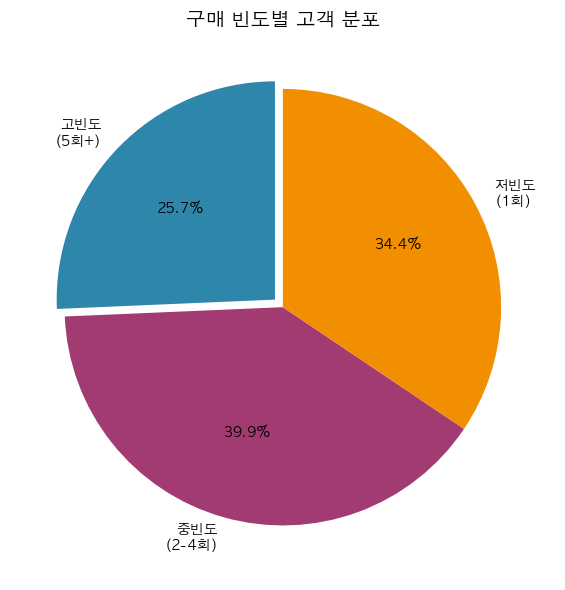


핵심 인사이트:
- 34.4%의 고객이 단 1회만 구매 (일회성 고객)
- 일회성 고객의 재방문 유도가 중요한 과제


In [13]:
# 구매 빈도 분포 시각화
fig, ax = plt.subplots(figsize=(10, 6))

freq_counts = [len(freq_high), len(freq_medium), len(freq_low)]
freq_labels = ['고빈도\n(5회+)', '중빈도\n(2-4회)', '저빈도\n(1회)']
colors = ['#2E86AB', '#A23B72', '#F18F01']

wedges, texts, autotexts = ax.pie(freq_counts, labels=freq_labels, autopct='%1.1f%%', 
                                   colors=colors, explode=(0.05, 0, 0), startangle=90)
ax.set_title('구매 빈도별 고객 분포', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n핵심 인사이트:")
print(f"- 34.4%의 고객이 단 1회만 구매 (일회성 고객)")
print(f"- 일회성 고객의 재방문 유도가 중요한 과제")

---
## 5. 시간 기반 코호트 분석

### 5.1 요일별 첫 구매 코호트

In [14]:
# 요일별 분석
df['FirstOrderWeekday'] = df['FirstOrderDate'].dt.dayofweek
weekday_names = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']

customer_first_weekday = df.groupby('CustomerID')['FirstOrderWeekday'].first()

weekday_stats = []
for day_num in range(7):
    day_customers = customer_first_weekday[customer_first_weekday == day_num].index
    if len(day_customers) > 0:
        day_df = df[df['CustomerID'].isin(day_customers)]
        day_cohort = day_df.groupby(['FirstOrderDate', 'CohortIndex'])['CustomerID'].nunique().unstack()
        day_size = day_cohort.iloc[:, 0]
        day_retention = day_cohort.divide(day_size, axis=0)
        avg_ret = day_retention.iloc[:, 1:].mean().mean() if day_retention.shape[1] > 1 else 0
        avg_sales = day_df.groupby('CustomerID')['Sales'].sum().mean()
        
        weekday_stats.append({
            '요일': weekday_names[day_num],
            '고객 수': len(day_customers),
            '평균 구매금액': avg_sales,
            '리텐션율': avg_ret
        })

weekday_df = pd.DataFrame(weekday_stats)
weekday_df

,요일,고객 수,평균 구매금액,리텐션율
0,월요일,169,1158.375089,0.205621
1,화요일,1155,1198.721463,0.210772
2,수요일,1127,4236.477329,0.330590
3,목요일,340,763.644650,0.216276
4,금요일,488,961.989348,0.196543
5,토요일,775,1740.181743,0.259748
6,일요일,284,1600.983908,0.190644


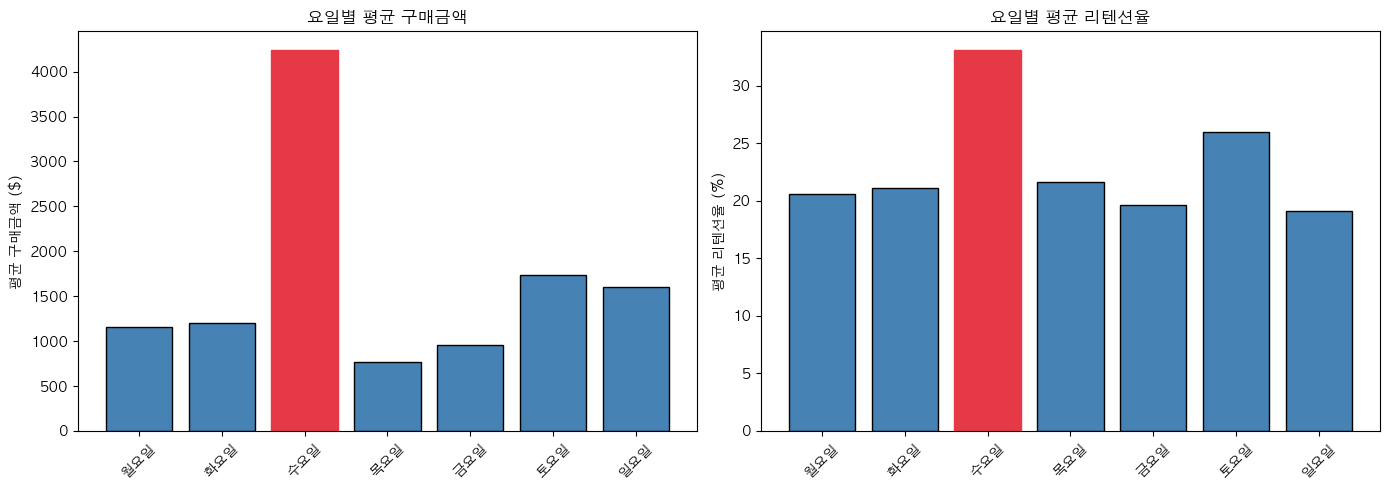


핵심 인사이트:
- 수요일 첫 구매 고객이 가장 높은 평균 구매금액과 리텐션율
- 주중 마케팅 캠페인 효과가 높을 것으로 예상


In [15]:
# 요일별 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 평균 구매금액
bars1 = axes[0].bar(weekday_df['요일'], weekday_df['평균 구매금액'], color='steelblue', edgecolor='black')
axes[0].set_title('요일별 평균 구매금액', fontsize=12, fontweight='bold')
axes[0].set_ylabel('평균 구매금액 ($)')
axes[0].tick_params(axis='x', rotation=45)

# 수요일 강조
max_idx = weekday_df['평균 구매금액'].idxmax()
bars1[max_idx].set_color('#E63946')

# 리텐션율
bars2 = axes[1].bar(weekday_df['요일'], weekday_df['리텐션율'] * 100, color='steelblue', edgecolor='black')
axes[1].set_title('요일별 평균 리텐션율', fontsize=12, fontweight='bold')
axes[1].set_ylabel('평균 리텐션율 (%)')
axes[1].tick_params(axis='x', rotation=45)

# 수요일 강조
max_idx2 = weekday_df['리텐션율'].idxmax()
bars2[max_idx2].set_color('#E63946')

plt.tight_layout()
plt.show()

print("\n핵심 인사이트:")
print("- 수요일 첫 구매 고객이 가장 높은 평균 구매금액과 리텐션율")
print("- 주중 마케팅 캠페인 효과가 높을 것으로 예상")

### 5.2 시즌별 코호트 분석

In [16]:
# 시즌 정의 함수
def get_season(month):
    if month in [12, 1, 2]:
        return '겨울'
    elif month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    else:
        return '가을'

df['FirstOrderMonth'] = df['FirstOrderDate'].dt.month
df['FirstOrderSeason'] = df['FirstOrderMonth'].apply(get_season)

season_stats = []
for season in ['봄', '여름', '가을', '겨울']:
    season_df = df[df['FirstOrderSeason'] == season]
    season_customers = season_df['CustomerID'].nunique()
    season_cohort = season_df.groupby(['FirstOrderDate', 'CohortIndex'])['CustomerID'].nunique().unstack()
    season_size = season_cohort.iloc[:, 0]
    season_retention = season_cohort.divide(season_size, axis=0)
    avg_ret = season_retention.iloc[:, 1:].mean().mean() if season_retention.shape[1] > 1 else 0
    avg_sales = season_df.groupby('CustomerID')['Sales'].sum().mean()
    
    season_stats.append({
        '시즌': season,
        '신규 고객 수': season_customers,
        '평균 구매금액': avg_sales,
        '평균 리텐션율': avg_ret
    })

season_df_result = pd.DataFrame(season_stats)
season_df_result

,시즌,신규 고객 수,평균 구매금액,평균 리텐션율
0,봄,1036,1372.655503,0.190345
1,여름,599,1021.692339,0.193703
2,가을,980,621.094144,0.172247
3,겨울,1723,3624.185619,0.292520


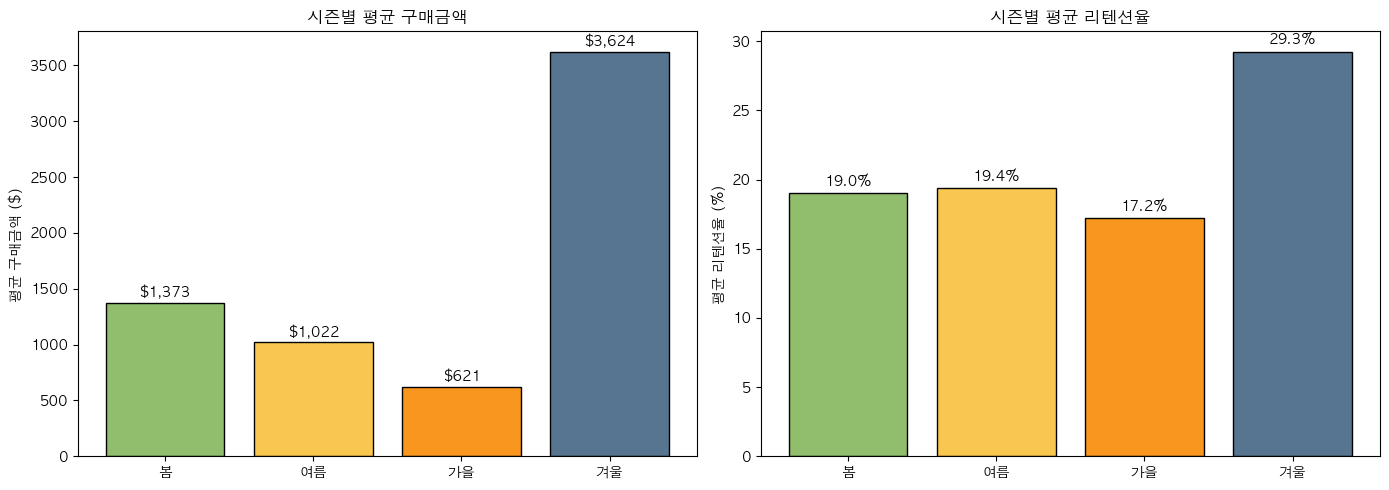


핵심 인사이트:
- 겨울 시즌 가입 고객이 압도적으로 높은 LTV와 리텐션율
- 연말 시즌 마케팅 효과가 장기적 고객 가치로 이어짐


In [17]:
# 시즌별 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

season_colors = ['#90BE6D', '#F9C74F', '#F8961E', '#577590']

# 평균 구매금액
bars1 = axes[0].bar(season_df_result['시즌'], season_df_result['평균 구매금액'], 
                     color=season_colors, edgecolor='black')
axes[0].set_title('시즌별 평균 구매금액', fontsize=12, fontweight='bold')
axes[0].set_ylabel('평균 구매금액 ($)')

for i, v in enumerate(season_df_result['평균 구매금액']):
    axes[0].text(i, v + 50, f'${v:,.0f}', ha='center', fontsize=10)

# 평균 리텐션율
bars2 = axes[1].bar(season_df_result['시즌'], season_df_result['평균 리텐션율'] * 100, 
                     color=season_colors, edgecolor='black')
axes[1].set_title('시즌별 평균 리텐션율', fontsize=12, fontweight='bold')
axes[1].set_ylabel('평균 리텐션율 (%)')

for i, v in enumerate(season_df_result['평균 리텐션율']):
    axes[1].text(i, v * 100 + 0.5, f'{v*100:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n핵심 인사이트:")
print("- 겨울 시즌 가입 고객이 압도적으로 높은 LTV와 리텐션율")
print("- 연말 시즌 마케팅 효과가 장기적 고객 가치로 이어짐")

---
## 6. 고객 생애 가치 (LTV) 분석

### 6.1 코호트별 평균 LTV

In [18]:
# 코호트별 평균 LTV 계산
cohort_ltv = df.groupby('FirstOrderDate').apply(
    lambda x: x.groupby('CustomerID')['Sales'].sum().mean()
)

# LTV 테이블
ltv_df = pd.DataFrame({
    '코호트': cohort_ltv.index.strftime('%Y-%m'),
    '평균 LTV': cohort_ltv.values,
    '전체 평균 대비': cohort_ltv.values / cohort_ltv.mean()
})
ltv_df['평균 LTV'] = ltv_df['평균 LTV'].apply(lambda x: f"${x:,.2f}")
ltv_df['전체 평균 대비'] = ltv_df['전체 평균 대비'].apply(lambda x: f"{x:.1f}배")

print(f"전체 평균 LTV: ${cohort_ltv.mean():,.2f}")
ltv_df

전체 평균 LTV: $1,463.62


,코호트,평균 LTV,전체 평균 대비
0,2010-12,"$5,087.02",3.5배
1,2011-01,"$2,692.94",1.8배
2,2011-02,"$1,559.21",1.1배
3,2011-03,"$1,419.62",1.0배
4,2011-04,"$1,085.74",0.7배
5,2011-05,"$1,600.98",1.1배
6,2011-06,"$1,126.03",0.8배
7,2011-07,$764.51,0.5배
8,2011-08,"$1,158.38",0.8배
9,2011-09,$778.04,0.5배


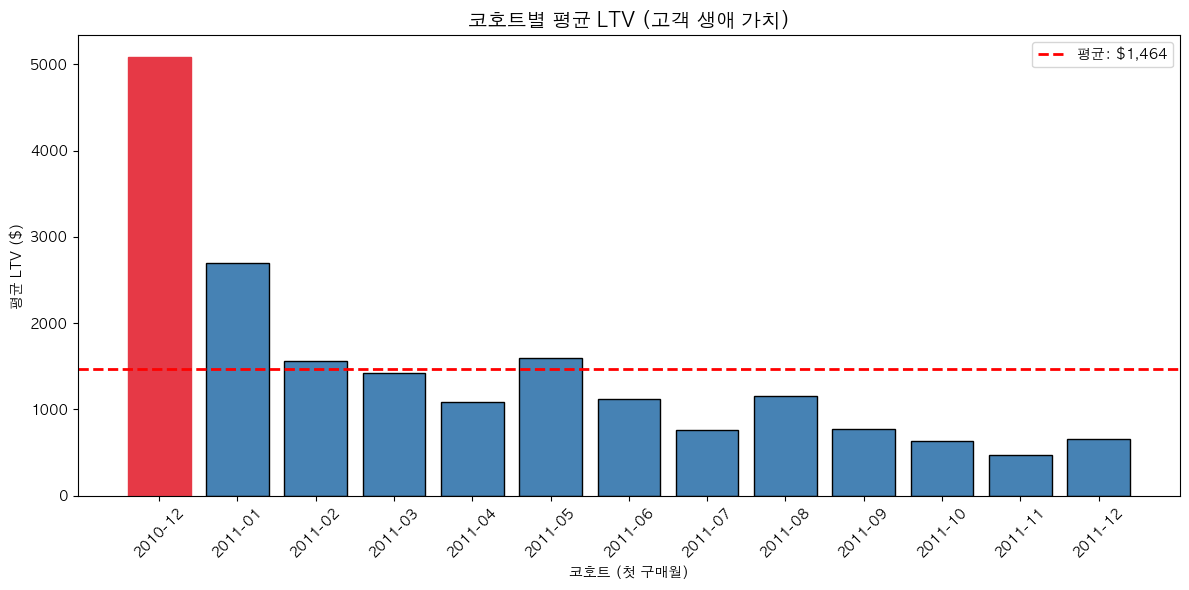


핵심 인사이트:
- 초기 코호트(2010-12)의 LTV가 후기 코호트 대비 7~10배 높음
- 시간이 지날수록 고객 품질이 하락하는 경향


In [19]:
# LTV 시각화
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(cohort_ltv.index.strftime('%Y-%m'), cohort_ltv.values, color='steelblue', edgecolor='black')
ax.axhline(y=cohort_ltv.mean(), color='red', linestyle='--', linewidth=2, label=f'평균: ${cohort_ltv.mean():,.0f}')

ax.set_title('코호트별 평균 LTV (고객 생애 가치)', fontsize=14, fontweight='bold')
ax.set_xlabel('코호트 (첫 구매월)')
ax.set_ylabel('평균 LTV ($)')
ax.tick_params(axis='x', rotation=45)
ax.legend()

# 첫 코호트 강조
bars[0].set_color('#E63946')

plt.tight_layout()
plt.show()

print("\n핵심 인사이트:")
print("- 초기 코호트(2010-12)의 LTV가 후기 코호트 대비 7~10배 높음")
print("- 시간이 지날수록 고객 품질이 하락하는 경향")

### 6.2 코호트별 매출 기여도

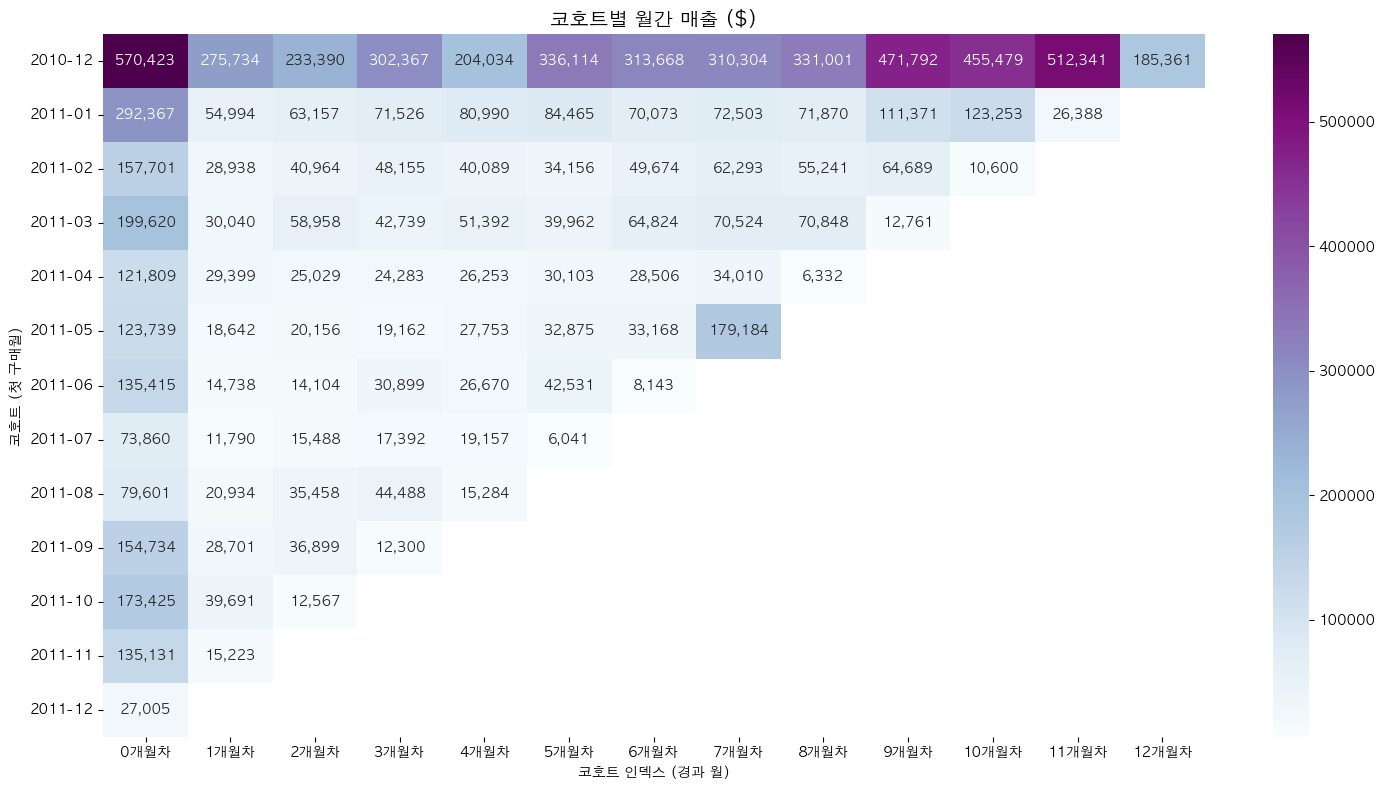

In [20]:
# 코호트별 매출 기여도
total_revenue = df['Sales'].sum()
cohort_revenue_total = df.groupby('FirstOrderDate')['Sales'].sum()

# 누적 매출 히트맵
cohort_revenue = df.groupby(['FirstOrderDate', 'CohortIndex'])['Sales'].sum().unstack()

plt.figure(figsize=(15, 8))
plt.title('코호트별 월간 매출 ($)', fontsize=14, fontweight='bold')
sns.heatmap(
    data=cohort_revenue,
    annot=True,
    fmt=',.0f',
    cmap="BuPu",
    xticklabels=[f'{i}개월차' for i in range(cohort_revenue.shape[1])],
    yticklabels=cohort_revenue.index.strftime('%Y-%m')
)
plt.xlabel('코호트 인덱스 (경과 월)')
plt.ylabel('코호트 (첫 구매월)')
plt.tight_layout()
plt.show()

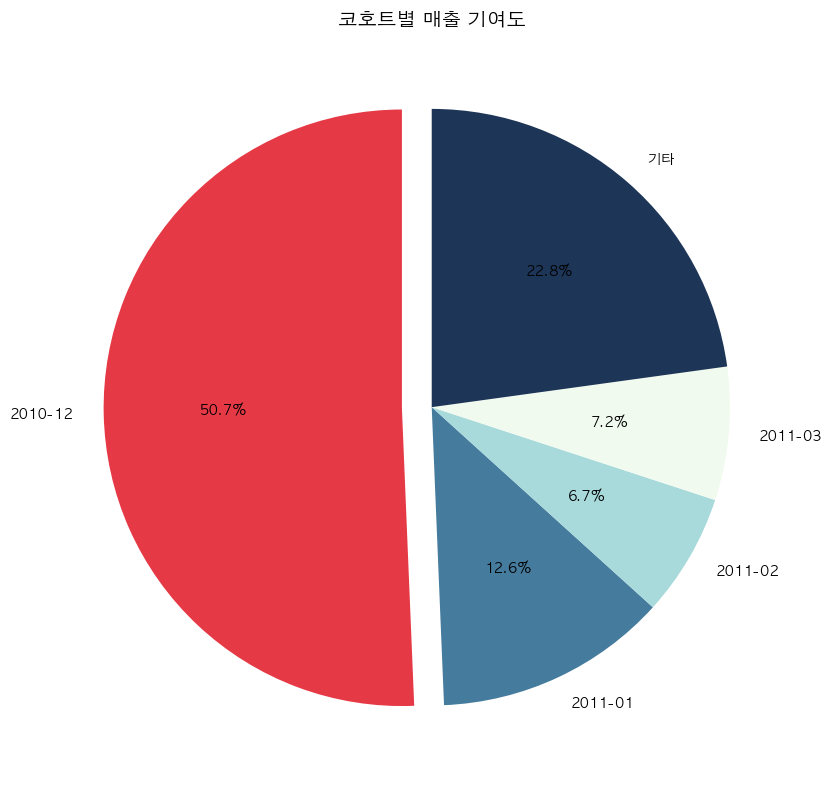


핵심 인사이트:
- 2010년 12월 코호트가 전체 매출의 절반 이상 기여
- 초기 고객의 누적 가치가 매우 높음


In [ ]:
# 매출 기여도 파이 차트
fig, ax = plt.subplots(figsize=(10, 8))

contribution = cohort_revenue_total / total_revenue * 100

# 상위 4개 + 기타로 그룹화
top_cohorts = contribution.head(4)
others = contribution[4:].sum()

labels = list(top_cohorts.index.strftime('%Y-%m')) + ['기타']
sizes = list(top_cohorts.values) + [others]

colors = ['#E63946', '#457B9D', '#A8DADC', '#F1FAEE', '#1D3557']
explode = (0.1, 0, 0, 0, 0)

wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', 
                                   colors=colors, explode=explode, startangle=90)
ax.set_title('코호트별 매출 기여도', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n핵심 인사이트:")
print("- 2010년 12월 코호트가 전체 매출의 절반 이상 기여")
print("- 초기 고객의 누적 가치가 매우 높음")

---
## 7. 재구매 행동 분석

### 7.1 재구매 통계

In [22]:
# 고객별 구매 날짜
customer_orders = df.groupby('CustomerID')['InvoiceDate'].apply(lambda x: sorted(x.unique()))
repeat_customers = customer_orders[customer_orders.apply(len) > 1]

# 첫 재구매까지의 기간 계산
first_repurchase_gaps = []
for orders in repeat_customers:
    if len(orders) > 1:
        gap = (orders[1] - orders[0]).days
        first_repurchase_gaps.append(gap)

repurchase_stats = {
    '지표': ['재구매 고객 수', '일회성 고객 수', '첫 재구매까지 평균 기간', '첫 재구매까지 중앙값'],
    '값': [
        f"{len(repeat_customers):,}명 ({len(repeat_customers)/df['CustomerID'].nunique()*100:.1f}%)",
        f"{df['CustomerID'].nunique() - len(repeat_customers):,}명 ({(df['CustomerID'].nunique() - len(repeat_customers))/df['CustomerID'].nunique()*100:.1f}%)",
        f"{np.mean(first_repurchase_gaps):.1f}일",
        f"{np.median(first_repurchase_gaps):.1f}일"
    ]
}

pd.DataFrame(repurchase_stats)

,지표,값
0,재구매 고객 수,"2,843명 (65.5%)"
1,일회성 고객 수,"1,495명 (34.5%)"
2,첫 재구매까지 평균 기간,76.1일
3,첫 재구매까지 중앙값,50.0일


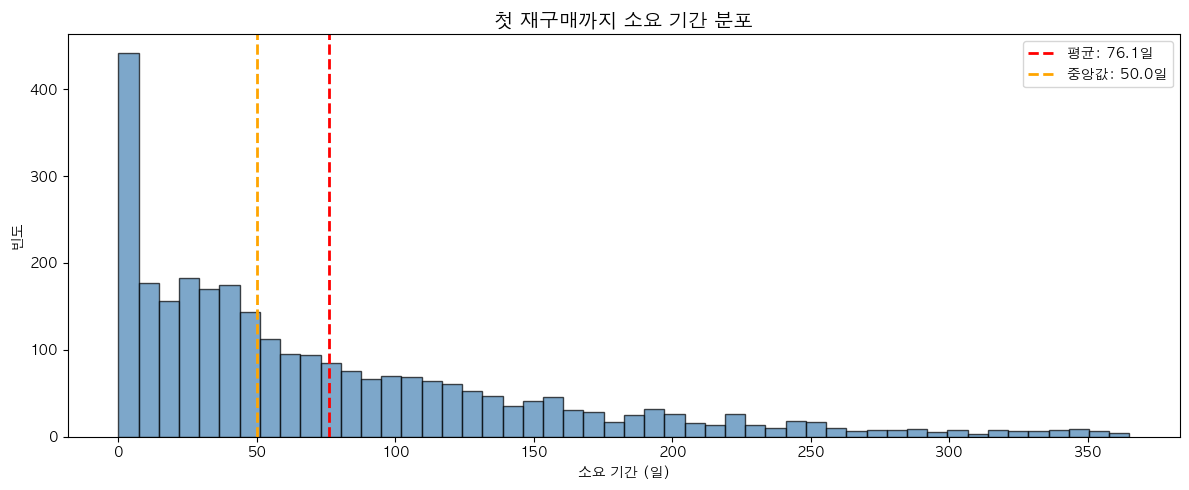


핵심 인사이트:
- 65.5%의 고객이 최소 1회 이상 재구매
- 첫 재구매까지 약 2.5개월 소요


In [23]:
# 재구매 간격 분포
fig, ax = plt.subplots(figsize=(12, 5))

ax.hist(first_repurchase_gaps, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(x=np.mean(first_repurchase_gaps), color='red', linestyle='--', linewidth=2, 
           label=f'평균: {np.mean(first_repurchase_gaps):.1f}일')
ax.axvline(x=np.median(first_repurchase_gaps), color='orange', linestyle='--', linewidth=2,
           label=f'중앙값: {np.median(first_repurchase_gaps):.1f}일')

ax.set_title('첫 재구매까지 소요 기간 분포', fontsize=14, fontweight='bold')
ax.set_xlabel('소요 기간 (일)')
ax.set_ylabel('빈도')
ax.legend()

plt.tight_layout()
plt.show()

print("\n핵심 인사이트:")
print("- 65.5%의 고객이 최소 1회 이상 재구매")
print("- 첫 재구매까지 약 2.5개월 소요")

### 7.2 주간 리텐션 분석 (첫 4주)

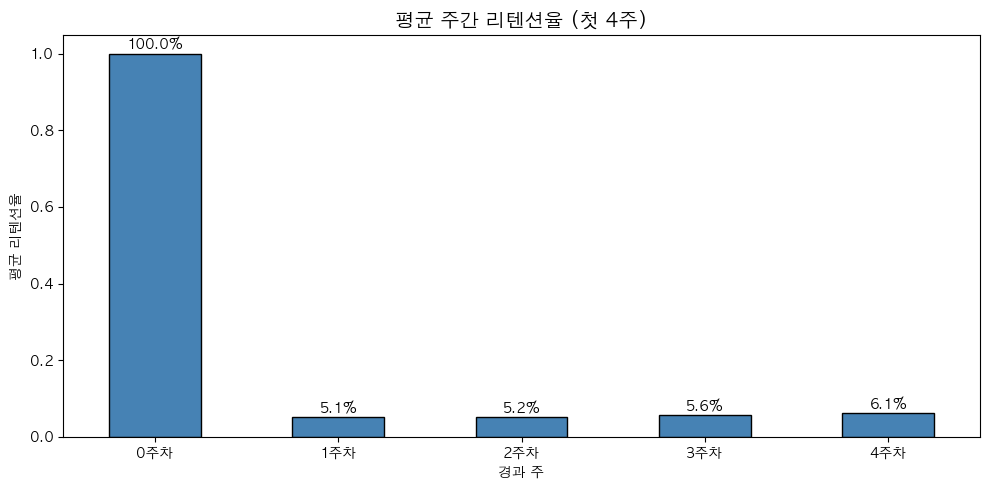


핵심 인사이트:
- 첫 주 이탈이 가장 큼 → 초기 리텐션 전략 필요


In [24]:
# 주간 리텐션 분석
df['InvoiceWeek'] = df['InvoiceDate'].dt.to_period('W').dt.to_timestamp()
df['FirstOrderWeek'] = df.groupby('CustomerID')['InvoiceWeek'].transform('min')
df['WeekCohortIndex'] = ((df['InvoiceWeek'] - df['FirstOrderWeek']).dt.days / 7).astype(int)

# 첫 4주 리텐션
week_cohort = df[df['WeekCohortIndex'] <= 4].groupby(['FirstOrderWeek', 'WeekCohortIndex'])['CustomerID'].nunique().unstack()
week_size = week_cohort.iloc[:, 0]
week_retention = week_cohort.divide(week_size, axis=0)

avg_week_retention = week_retention.mean()

# 시각화
fig, ax = plt.subplots(figsize=(10, 5))
avg_week_retention.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('평균 주간 리텐션율 (첫 4주)', fontsize=14, fontweight='bold')
ax.set_xlabel('경과 주')
ax.set_ylabel('평균 리텐션율')
ax.set_xticklabels([f'{i}주차' for i in range(len(avg_week_retention))], rotation=0)

for i, v in enumerate(avg_week_retention):
    if not pd.isna(v):
        ax.text(i, v + 0.01, f'{v:.1%}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n핵심 인사이트:")
print("- 첫 주 이탈이 가장 큼 → 초기 리텐션 전략 필요")

---
## 8. 신규 vs 재방문 고객 비교

In [25]:
# 신규 vs 재방문 비교
df['IsNewCustomer'] = df['CohortIndex'] == 0

new_customer_stats = df[df['IsNewCustomer'] == True].groupby('CustomerID').agg({
    'Sales': 'sum',
    'InvoiceNo': 'nunique',
    'Quantity': 'sum'
}).mean()

repeat_customer_stats = df[df['IsNewCustomer'] == False].groupby('CustomerID').agg({
    'Sales': 'sum',
    'InvoiceNo': 'nunique',
    'Quantity': 'sum'
}).mean()

comparison_df = pd.DataFrame({
    '지표': ['평균 매출', '평균 주문 수', '평균 구매 수량'],
    '신규 고객 (첫 달)': [
        f"${new_customer_stats['Sales']:,.2f}",
        f"{new_customer_stats['InvoiceNo']:.1f}회",
        f"{new_customer_stats['Quantity']:,.1f}개"
    ],
    '재방문 고객': [
        f"${repeat_customer_stats['Sales']:,.2f}",
        f"{repeat_customer_stats['InvoiceNo']:.1f}회",
        f"{repeat_customer_stats['Quantity']:,.1f}개"
    ]
})
comparison_df

,지표,신규 고객 (첫 달),재방문 고객
0,평균 매출,$517.48,"$2,456.50"
1,평균 주문 수,1.2회,4.9회
2,평균 구매 수량,303.3개,"1,418.8개"


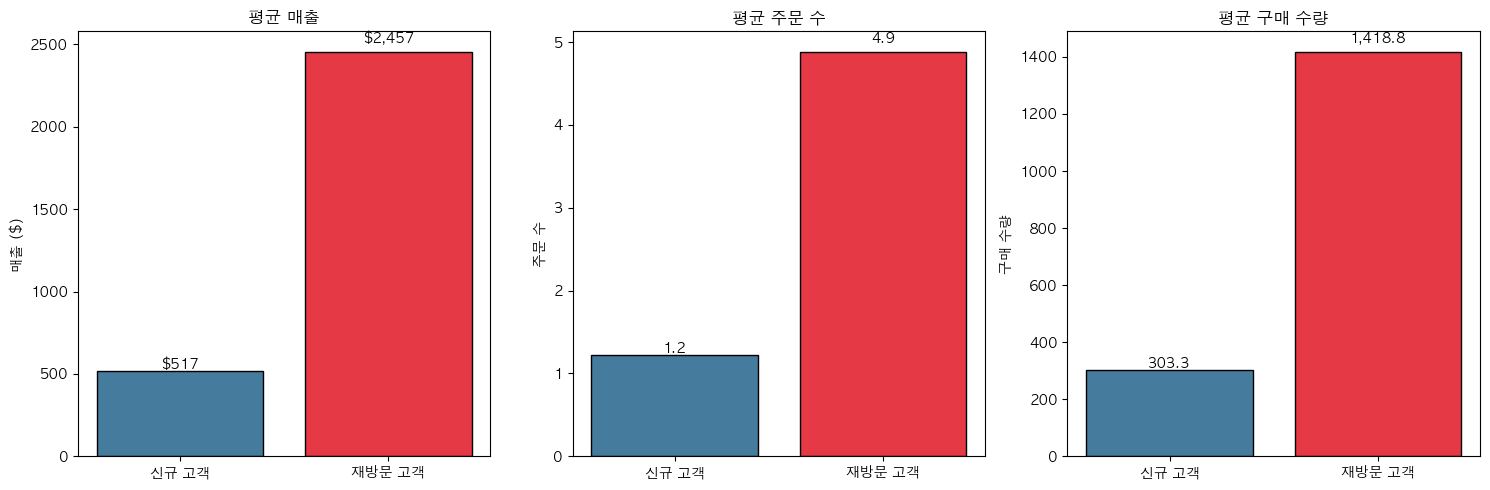


핵심 인사이트:
- 재방문 고객이 신규 대비 4.7배 높은 매출 기여
- 고객 유지가 신규 확보보다 ROI가 높음


In [26]:
# 비교 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['Sales', 'InvoiceNo', 'Quantity']
titles = ['평균 매출', '평균 주문 수', '평균 구매 수량']
ylabels = ['매출 ($)', '주문 수', '구매 수량']

for i, (metric, title, ylabel) in enumerate(zip(metrics, titles, ylabels)):
    values = [new_customer_stats[metric], repeat_customer_stats[metric]]
    bars = axes[i].bar(['신규 고객', '재방문 고객'], values, color=['#457B9D', '#E63946'], edgecolor='black')
    axes[i].set_title(title, fontsize=12, fontweight='bold')
    axes[i].set_ylabel(ylabel)
    
    for j, v in enumerate(values):
        if metric == 'Sales':
            axes[i].text(j, v + v*0.02, f'${v:,.0f}', ha='center', fontsize=10)
        else:
            axes[i].text(j, v + v*0.02, f'{v:,.1f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n핵심 인사이트:")
print(f"- 재방문 고객이 신규 대비 {repeat_customer_stats['Sales']/new_customer_stats['Sales']:.1f}배 높은 매출 기여")
print("- 고객 유지가 신규 확보보다 ROI가 높음")

---
## 9. RFM 분석 기반 고객 세그먼트

### 9.1 RFM 계산

In [27]:
# RFM 계산
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'Sales': 'sum'  # Monetary
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

# RFM 통계
rfm_stats = pd.DataFrame({
    '지표': ['Recency (마지막 구매 후 경과일)', 'Frequency (구매 빈도)', 'Monetary (총 구매금액)'],
    '평균값': [
        f"{rfm['Recency'].mean():.1f}일",
        f"{rfm['Frequency'].mean():.1f}회",
        f"${rfm['Monetary'].mean():,.2f}"
    ]
})
rfm_stats

,지표,평균값
0,Recency (마지막 구매 후 경과일),92.5일
1,Frequency (구매 빈도),4.3회
2,Monetary (총 구매금액),"$2,048.69"


In [28]:
# RFM 점수 부여 (1-5)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# 고객 세그먼트 정의
def segment_customer(r, f, m):
    r, f, m = int(r), int(f), int(m)
    if r >= 4 and f >= 4:
        return 'Champions'
    elif r >= 4 and f >= 2:
        return 'Loyal Customers'
    elif r >= 3 and f >= 3:
        return 'Potential Loyalists'
    elif r >= 4 and f == 1:
        return 'New Customers'
    elif r >= 2 and f >= 2:
        return 'At Risk'
    elif r <= 2 and f >= 4:
        return "Can't Lose Them"
    elif r <= 2 and f <= 2:
        return 'Lost'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(lambda x: segment_customer(x['R_Score'], x['F_Score'], x['M_Score']), axis=1)

rfm.head(10)

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
CustomerID,,,,,,,,
12346,326,1,77183.60,1,1,5,115,Lost
12347,2,7,4310.00,5,5,5,555,Champions
12348,75,4,1797.24,2,4,4,244,At Risk
12349,19,1,1757.55,4,1,4,414,New Customers
12350,310,1,334.40,1,1,2,112,Lost
12352,36,8,2506.04,3,5,5,355,Potential Loyalists
12353,204,1,89.00,1,1,1,111,Lost
12354,232,1,1079.40,1,1,4,114,Lost
12355,214,1,459.40,1,1,2,112,Lost


### 9.2 고객 세그먼트 분포

In [29]:
# 세그먼트별 통계
segment_analysis = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(2)

segment_analysis.columns = ['평균 Recency', '평균 Frequency', '평균 Monetary', '고객 수']
segment_analysis['비중'] = (segment_analysis['고객 수'] / len(rfm) * 100).round(1)
segment_analysis = segment_analysis.sort_values('고객 수', ascending=False)
segment_analysis

,평균 Recency,평균 Frequency,평균 Monetary,고객 수,비중
Segment,,,,,
Champions,13.31,9.99,5191.77,1139,26.3
Lost,241.18,1.05,473.01,863,19.9
At Risk,101.61,2.52,912.45,831,19.2
Potential Loyalists,51.49,4.45,1850.77,507,11.7
Loyal Customers,17.12,2.01,1030.11,492,11.3
Others,139.75,1.56,784.72,306,7.1
New Customers,18.50,1.00,362.78,141,3.3
Can't Lose Them,233.53,4.93,1201.78,59,1.4


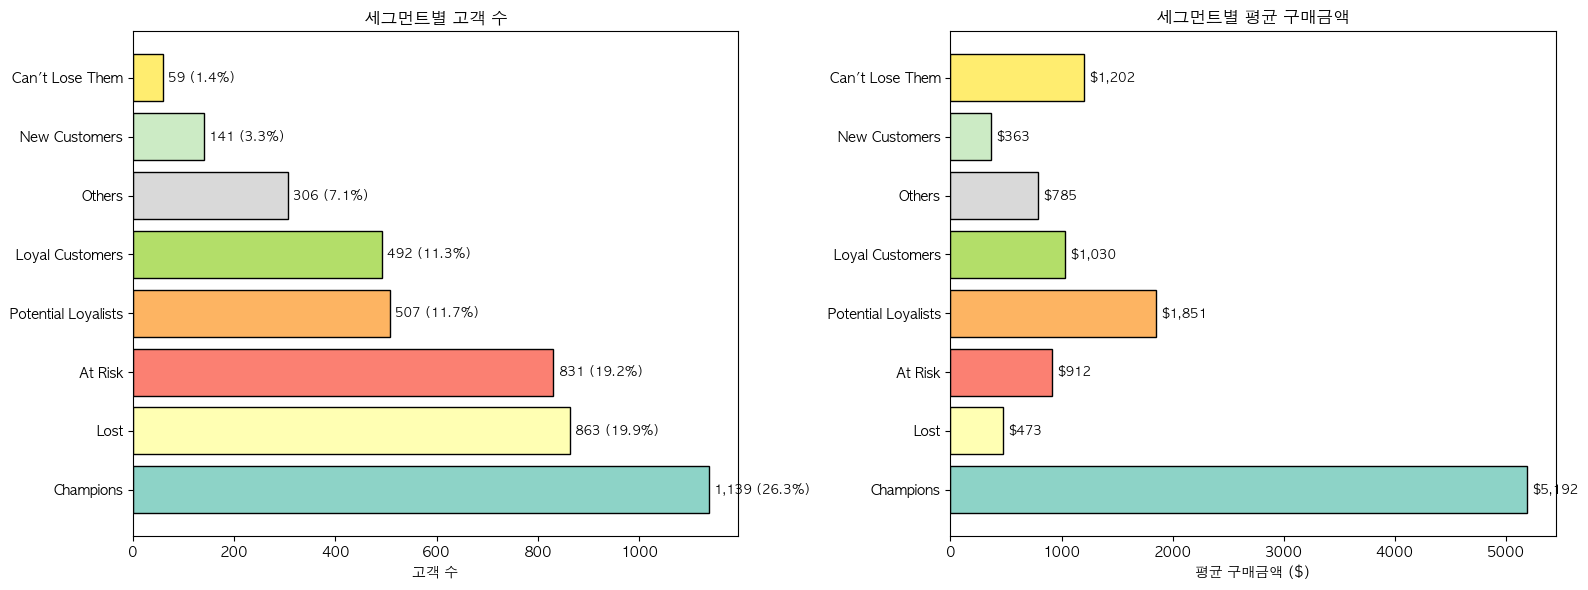

In [30]:
# 세그먼트 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 고객 수 분포
segment_counts = rfm['Segment'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(segment_counts)))

bars = axes[0].barh(segment_counts.index, segment_counts.values, color=colors, edgecolor='black')
axes[0].set_title('세그먼트별 고객 수', fontsize=12, fontweight='bold')
axes[0].set_xlabel('고객 수')

for i, v in enumerate(segment_counts.values):
    axes[0].text(v + 10, i, f'{v:,} ({v/len(rfm)*100:.1f}%)', va='center', fontsize=9)

# 평균 구매금액 분포
segment_monetary = rfm.groupby('Segment')['Monetary'].mean().reindex(segment_counts.index)
bars2 = axes[1].barh(segment_monetary.index, segment_monetary.values, color=colors, edgecolor='black')
axes[1].set_title('세그먼트별 평균 구매금액', fontsize=12, fontweight='bold')
axes[1].set_xlabel('평균 구매금액 ($)')

for i, v in enumerate(segment_monetary.values):
    axes[1].text(v + 50, i, f'${v:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [31]:
# 세그먼트별 전략 제안
strategy_map = {
    'Champions': 'VIP 혜택, 신제품 우선 제공',
    'Loyal Customers': '크로스셀/업셀',
    'Potential Loyalists': '로열티 프로그램 가입 유도',
    'New Customers': '웰컴 시리즈, 온보딩',
    'At Risk': '긴급 리텐션 프로모션',
    "Can't Lose Them": '긴급 윈백 캠페인',
    'Lost': '재활성화 캠페인',
    'Others': '맞춤형 추천'
}

strategy_df = pd.DataFrame([
    {
        '세그먼트': seg,
        '고객 수': f"{segment_counts.get(seg, 0):,}명",
        '비중': f"{segment_counts.get(seg, 0)/len(rfm)*100:.1f}%",
        '평균 구매금액': f"${rfm[rfm['Segment']==seg]['Monetary'].mean():,.2f}",
        '전략 제안': strategy_map[seg]
    }
    for seg in segment_counts.index
])

strategy_df

,세그먼트,고객 수,비중,평균 구매금액,전략 제안
0,Champions,"1,139명",26.3%,"$5,191.77","VIP 혜택, 신제품 우선 제공"
1,Lost,863명,19.9%,$473.01,재활성화 캠페인
2,At Risk,831명,19.2%,$912.45,긴급 리텐션 프로모션
3,Potential Loyalists,507명,11.7%,"$1,850.77",로열티 프로그램 가입 유도
4,Loyal Customers,492명,11.3%,"$1,030.11",크로스셀/업셀
5,Others,306명,7.1%,$784.72,맞춤형 추천
6,New Customers,141명,3.3%,$362.78,"웰컴 시리즈, 온보딩"
7,Can't Lose Them,59명,1.4%,"$1,201.78",긴급 윈백 캠페인


---
## 10. 첫 구매 상품 분석

In [32]:
# 첫 구매 상품 파악
first_purchase = df.sort_values('InvoiceDate').groupby('CustomerID').first()

# 상위 10개 첫 구매 상품
top_first_products = first_purchase['Description'].value_counts().head(10)

# 테이블
first_product_df = pd.DataFrame({
    '순위': range(1, 11),
    '상품명': top_first_products.index,
    '고객 수': top_first_products.values
})
first_product_df

,순위,상품명,고객 수
0,1,POSTAGE,66
1,2,WHITE HANGING HEART T-LIGHT HOLDER,40
2,3,REGENCY CAKESTAND 3 TIER,38
3,4,JUMBO BAG RED RETROSPOT,27
4,5,PARTY BUNTING,23
5,6,ASSORTED COLOUR BIRD ORNAMENT,21
6,7,JAM MAKING SET WITH JARS,20
7,8,NATURAL SLATE HEART CHALKBOARD,19
8,9,REX CASH+CARRY JUMBO SHOPPER,17
9,10,WOODEN FRAME ANTIQUE WHITE,16


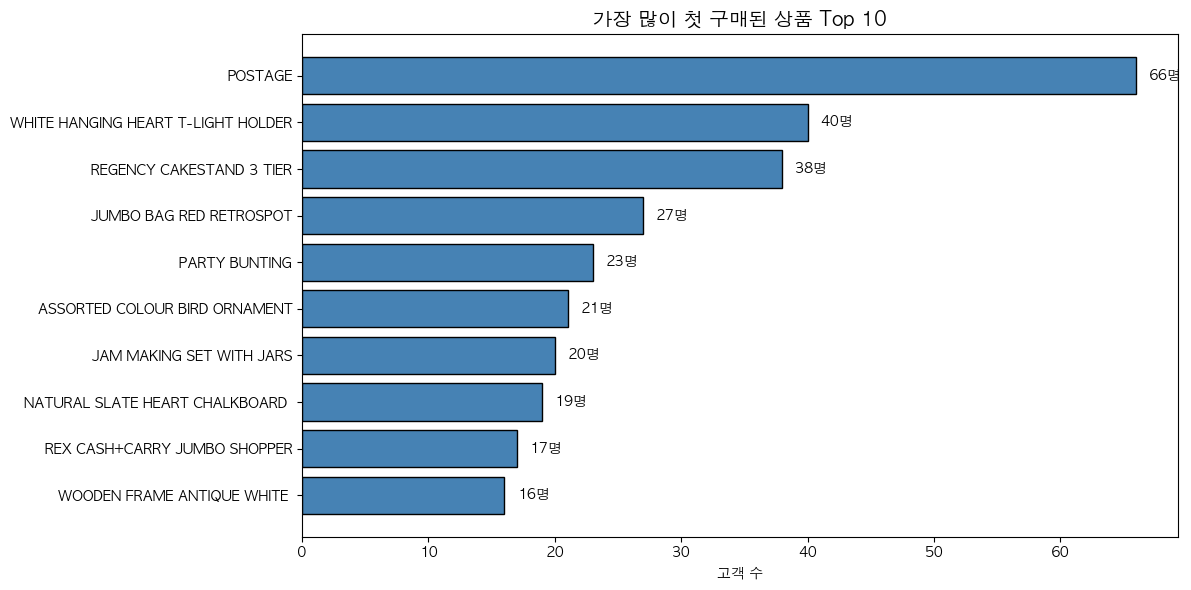


핵심 인사이트:
- 신규 고객 유입 상품 파악을 통한 마케팅 최적화 가능
- 인기 첫 구매 상품 기반 프로모션 전략 수립


In [33]:
# 시각화
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.barh(top_first_products.index[::-1], top_first_products.values[::-1], 
               color='steelblue', edgecolor='black')
ax.set_title('가장 많이 첫 구매된 상품 Top 10', fontsize=14, fontweight='bold')
ax.set_xlabel('고객 수')

for i, v in enumerate(top_first_products.values[::-1]):
    ax.text(v + 1, i, f'{v}명', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n핵심 인사이트:")
print("- 신규 고객 유입 상품 파악을 통한 마케팅 최적화 가능")
print("- 인기 첫 구매 상품 기반 프로모션 전략 수립")

---
## 11. 평균 주문 금액 (AOV) 분석

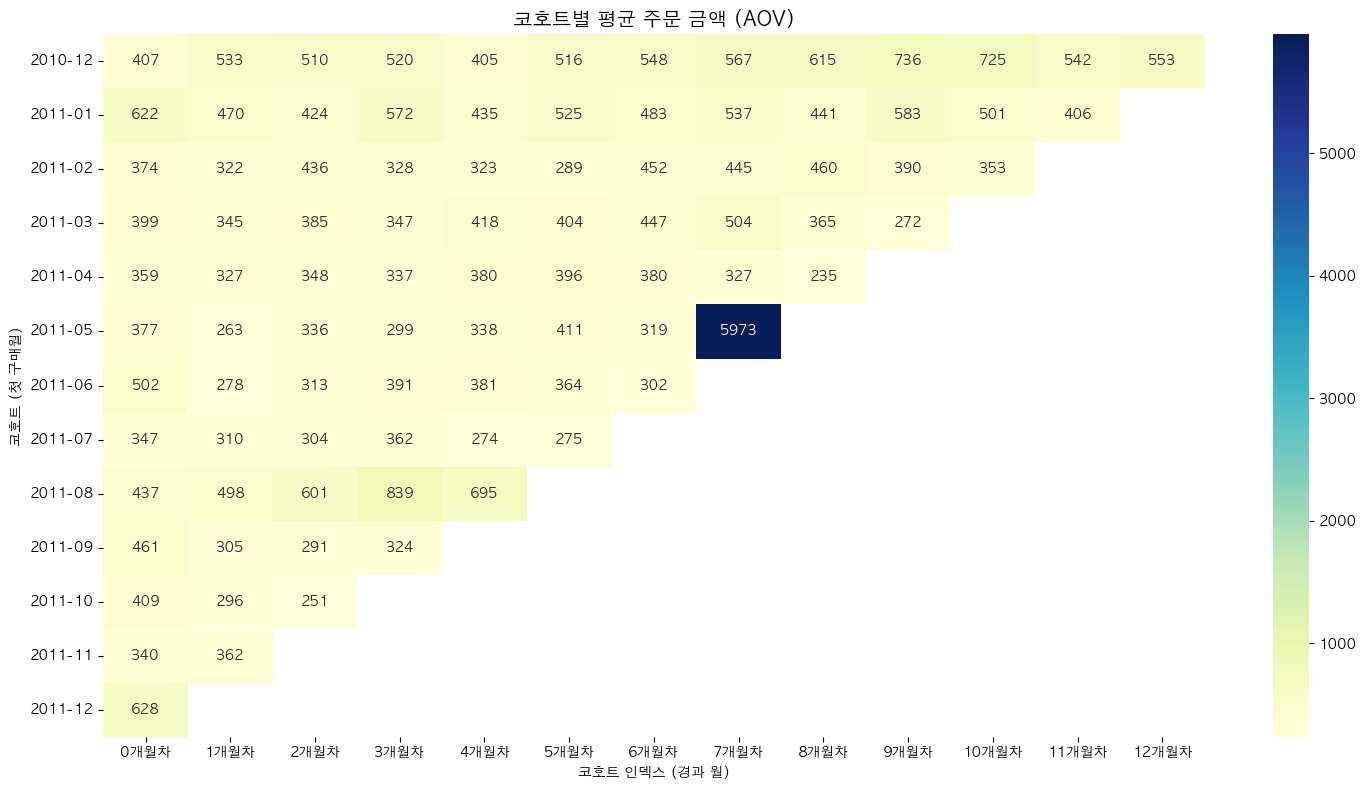


핵심 인사이트:
- 충성 고객일수록 주문당 금액이 증가하는 경향
- 장기 고객의 업셀링 기회 존재


In [34]:
# 코호트별 AOV
aov_by_cohort = df.groupby(['FirstOrderDate', 'CohortIndex']).apply(
    lambda x: x.groupby('InvoiceNo')['Sales'].sum().mean()
).unstack()

plt.figure(figsize=(15, 8))
plt.title('코호트별 평균 주문 금액 (AOV)', fontsize=14, fontweight='bold')
sns.heatmap(
    data=aov_by_cohort.round(0),
    annot=True,
    fmt='.0f',
    cmap="YlGnBu",
    xticklabels=[f'{i}개월차' for i in range(aov_by_cohort.shape[1])],
    yticklabels=aov_by_cohort.index.strftime('%Y-%m')
)
plt.xlabel('코호트 인덱스 (경과 월)')
plt.ylabel('코호트 (첫 구매월)')
plt.tight_layout()
plt.show()

print("\n핵심 인사이트:")
print("- 충성 고객일수록 주문당 금액이 증가하는 경향")
print("- 장기 고객의 업셀링 기회 존재")

---
## 12. 핵심 인사이트 요약 및 권장 전략

In [35]:
print("="*60)
print("주요 발견사항")
print("="*60)
print()
print("1. 첫 달 이탈률 79.4% - 초기 고객 경험 개선 시급")
print("2. 상위 25% 고객이 매출 대부분 기여 - VIP 관리 강화 필요")
print("3. 재방문 고객이 4.7배 높은 매출 - 리텐션 > 신규 확보")
print("4. 겨울 시즌 고객이 최고 LTV - 시즌별 차별화 전략")
print("5. 수요일 첫 구매 고객이 최고 성과 - 요일별 마케팅 최적화")
print()
print("="*60)
print("권장 전략")
print("="*60)
print()
print("[단기 전략 (1-3개월)]")
print("- 신규 고객 온보딩 이메일 시리즈 구축")
print("- 첫 구매 후 7일 내 재구매 할인 쿠폰 제공")
print("- At Risk 고객 대상 긴급 프로모션 실행")
print()
print("[중기 전략 (3-6개월)]")
print("- VIP 로열티 프로그램 런칭 (Champions 대상)")
print("- 일회성 고객 재활성화 캠페인 (푸시/이메일)")
print("- 수요일 집중 마케팅 캠페인 테스트")
print()
print("[장기 전략 (6-12개월)]")
print("- 해외 시장 확대 (독일, 프랑스 우선)")
print("- 연말 시즌 선제적 마케팅 강화")
print("- 고객 세분화 기반 개인화 추천 시스템 도입")

주요 발견사항

1. 첫 달 이탈률 79.4% - 초기 고객 경험 개선 시급
2. 상위 25% 고객이 매출 대부분 기여 - VIP 관리 강화 필요
3. 재방문 고객이 4.7배 높은 매출 - 리텐션 > 신규 확보
4. 겨울 시즌 고객이 최고 LTV - 시즌별 차별화 전략
5. 수요일 첫 구매 고객이 최고 성과 - 요일별 마케팅 최적화

권장 전략

[단기 전략 (1-3개월)]
- 신규 고객 온보딩 이메일 시리즈 구축
- 첫 구매 후 7일 내 재구매 할인 쿠폰 제공
- At Risk 고객 대상 긴급 프로모션 실행

[중기 전략 (3-6개월)]
- VIP 로열티 프로그램 런칭 (Champions 대상)
- 일회성 고객 재활성화 캠페인 (푸시/이메일)
- 수요일 집중 마케팅 캠페인 테스트

[장기 전략 (6-12개월)]
- 해외 시장 확대 (독일, 프랑스 우선)
- 연말 시즌 선제적 마케팅 강화
- 고객 세분화 기반 개인화 추천 시스템 도입


---
## 13. 결론

본 코호트 분석을 통해 고객 행동의 주요 패턴을 파악했습니다:

1. **고객 품질 관리**: 초기 코호트의 높은 LTV를 유지하면서, 후기 코호트의 품질을 높이는 전략 필요

2. **리텐션 집중**: 신규 고객 확보보다 기존 고객 유지가 ROI 측면에서 효율적

3. **세그먼트 기반 접근**: RFM 분석을 통한 고객 세그먼트별 맞춤 전략 실행

4. **시간/시즌 최적화**: 요일별, 시즌별 고객 행동 패턴에 맞춘 마케팅 타이밍 최적화

---

*보고서 생성일: 2025-12-05*  
*데이터 분석 기간: 2010-12-01 ~ 2011-12-09*  
*총 분석 대상: 4,338명의 고객, 392,692건의 거래*